
# Wine Quality Classification

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error

from imblearn.over_sampling import RandomOverSampler


In [35]:
df = pd.read_csv('/content/WineQuality.csv')

df.head()

,Unnamed: 0,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Type
0,2732,7.4,0.170,0.29,1.4,0.047,23.0,107.0,0.99390,3.52,0.65,10.4,6,White Wine
1,2607,5.3,0.310,0.38,10.5,0.031,53.0,140.0,0.99321,3.34,0.46,11.7,6,White Wine
2,1653,4.7,0.145,0.29,1.0,0.042,35.0,90.0,0.99080,3.76,0.49,11.3,6,White Wine
3,3264,6.9,0.260,0.29,4.2,0.043,33.0,114.0,0.99020,3.16,0.31,12.5,6,White Wine
4,4931,6.4,0.450,0.07,1.1,0.030,10.0,131.0,0.99050,2.97,0.28,10.8,5,White Wine


In [36]:
df.drop(labels = ['Unnamed: 0'], axis = 1, inplace = True)

In [37]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Type
0,7.4,0.170,0.29,1.4,0.047,23.0,107.0,0.99390,3.52,0.65,10.4,6,White Wine
1,5.3,0.310,0.38,10.5,0.031,53.0,140.0,0.99321,3.34,0.46,11.7,6,White Wine
2,4.7,0.145,0.29,1.0,0.042,35.0,90.0,0.99080,3.76,0.49,11.3,6,White Wine
3,6.9,0.260,0.29,4.2,0.043,33.0,114.0,0.99020,3.16,0.31,12.5,6,White Wine
4,6.4,0.450,0.07,1.1,0.030,10.0,131.0,0.99050,2.97,0.28,10.8,5,White Wine


In [38]:
df.isnull().sum() # No missing data

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
Type                    0
dtype: int64

In [39]:

df['quality'].value_counts()

# Only 3, 4, 5, 6, 7, 8, 9 are used (1, 2, 10 are not.)

6    14117
5    10755
7     5371
4     1144
8      941
3      133
9       24
Name: quality, dtype: int64

Split the quality into two parts
3, 4, 5, 6 meh
7, 8, 9 good

In [40]:
df['quality'] = df['quality'].apply(lambda x : 0 if 3 <= x <= 6 else 1)

In [41]:
df['quality'].value_counts()

0    26149
1     6336
Name: quality, dtype: int64

We have a difference of 19813 between each category...
We can oversample the "1" category

In [42]:
X = df.drop(['quality'], axis = 1)
y = df['quality']

In [43]:
oversampler = RandomOverSampler(sampling_strategy='auto')
X_resampled, y_resampled = oversampler.fit_resample(X, y)

In [44]:
y_resampled.value_counts()

0    26149
1    26149
Name: quality, dtype: int64

In [45]:
encoder = OneHotEncoder(
    drop = 'first',
    handle_unknown = 'error',
    sparse_output = False,
    categories = 'auto'
)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.3, random_state = 15)

In [47]:
ct = ColumnTransformer([('encoder', encoder, ['Type'])], verbose_feature_names_out=False, remainder='passthrough')
ct.set_output(transform = 'pandas')

X_train = ct.fit_transform(X_train)
X_test = ct.fit_transform(X_test)

In [48]:
X_train.shape, X_test.shape

((36608, 12), (15690, 12))

In [49]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [50]:
X_train.shape, X_test.shape

((36608, 12), (15690, 12))

# Min-Max Scaler
Scale the data to 0, 1 since some models do not accept negative numbers

In [55]:
from sklearn.preprocessing import MinMaxScaler

In [56]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train Multiple Models

In [57]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [58]:
models = {
    "KNN":KNeighborsClassifier(n_neighbors = 4),
    "SVM":SVC(),
    "NB-Gauss":GaussianNB(),
    "NB-Multi":MultinomialNB(),
    "NB-Berno":BernoulliNB(),
    "Logistic-R":LogisticRegression(max_iter=650),
    "Rnd-Fores":RandomForestClassifier()
}

In [59]:
def result(y_test, y_pred):
    r=[]
    r.append('%.4f' % r2_score(y_test,y_pred))                      # R2-Score
    r.append('%.4f' % (accuracy_score(y_test,y_pred)*100))          # Accuracy
    r.append('%.2f' % mean_squared_error(y_test, y_pred))           # MSE
    r.append('%.2f' % mean_absolute_error(y_test, y_pred))          # MAE
    r.append('%.2f' % np.sqrt(mean_squared_error(y_test, y_pred)))  # RMSE

    return (r)

#dataframe that store the performance of each model
score_data = pd.DataFrame(index=['R2 Score', 'Accuracy(%)', 'Mean Squared Error', 'Mean Absolute Error', 'Root MSE'])

In [60]:
for id, model in models.items():
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  score_lr = result(y_test, y_pred)
  score_data[id] = score_lr


In [61]:
score_data

,KNN,SVM,NB-Gauss,NB-Multi,NB-Berno,Logistic-R,Rnd-Fores
R2 Score,0.9709,0.1566,-0.3097,-0.2230,-1.0105,-0.0364,0.9985
Accuracy(%),99.2734,78.9165,67.2594,69.4264,49.7387,74.0918,99.9618
Mean Squared Error,0.01,0.21,0.33,0.31,0.50,0.26,0.00
Mean Absolute Error,0.01,0.21,0.33,0.31,0.50,0.26,0.00
Root MSE,0.09,0.46,0.57,0.55,0.71,0.51,0.02


In [62]:
for i in score_data.columns:
  score_data[i] = score_data[i].astype(float)

model_accuracy = score_data.loc['Accuracy(%)']

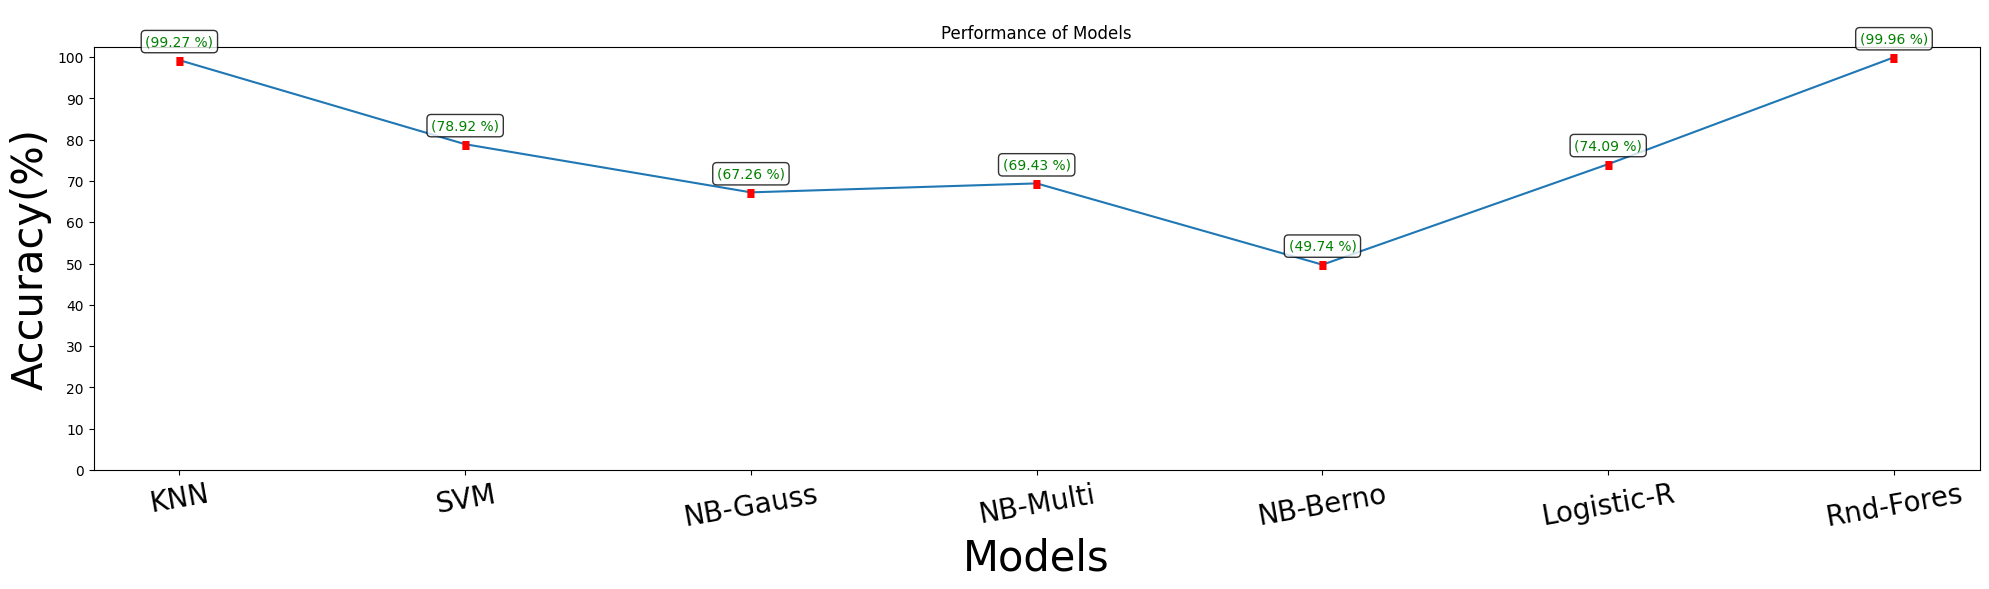

In [63]:
x = list(range(len(model_accuracy)))
y = list(range(0,101,10))

props = dict(boxstyle='round', facecolor='white', alpha=0.8)

plt.figure(figsize=(20,6))
plt.plot(model_accuracy)

plt.yticks(y)
plt.xticks(fontsize=20)
plt.xticks(rotation = (10))
plt.xlabel("Models",fontsize=30)
plt.ylabel("Accuracy(%)",fontsize=30)
plt.title("Performance of Models")

for a, b in zip(x,y):

    b=model_accuracy[a]
    val="("+str(round(model_accuracy[a],2))+" %)"

    plt.text(a, b+4.5, val,horizontalalignment='center',verticalalignment='center',color='green',bbox=props)
    plt.text(a, b+3.5, '.',horizontalalignment='center',verticalalignment='center',color='red',fontsize=50)

plt.tight_layout()
plt.show()


From the figure, we can see that KNN and Random Forests have much higher accuracy than other. Lets see if they have overfit their data or not

## KNN

In [64]:
KNN = KNeighborsClassifier(n_neighbors=4)
KNN.fit(X_train, y_train)
y_pred = KNN.predict(X_test)
train_accuracy = KNN.score(X_train, y_train)
test_accuracy = KNN.score(X_test, y_test)

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Training Accuracy: 0.9982517482517482
Test Accuracy: 0.9927342256214149


In [65]:
RND = RandomForestClassifier()
RND.fit(X_train, y_train)
y_pred = RND.predict(X_test)

train_accuracy = RND.score(X_train, y_train)
test_accuracy = RND.score(X_test, y_test)

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Training Accuracy: 1.0
Test Accuracy: 0.9995538559592096


# Since the Random Forest Classifier overfits the data while the KNN Model doesn't, I will have to go with the KNN Model Classifier for this problem